In [1]:
from erddapy import ERDDAP


server_url = 'https://data.ioos.us/gliders/erddap'

e = ERDDAP(server_url=server_url)

In [2]:
from datetime import datetime


def parse_dates(date_time, calendar='standard'):
    """
    ERDDAP can take a variety of time constraints, we chose to use only
    `seconds since 1970-01-01T00:00:00Z` so the user can parse the dates in any way they like,
    and provide a datetime object to this function.

    """
    from netCDF4 import netcdftime

    utime = netcdftime.utime('seconds since 1970-01-01T00:00:00Z', calendar=calendar)
    return utime.date2num(date_time)

In [3]:
min_time = datetime.strptime('2016-07-10T00:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
max_time = datetime.strptime('2017-02-10T00:00:00Z', '%Y-%m-%dT%H:%M:%SZ')
min_time, max_time = parse_dates(min_time), parse_dates(max_time)

min_lat, max_lat =  38.0, 41.0
min_lon, max_lon = -72.0, -69.0

standard_name = 'sea_water_temperature'

In [4]:
def show_iframe(src):
    from IPython.display import HTML
    iframe = '<iframe src="{src}" width="100%" height="950"></iframe>'.format
    return HTML(iframe(src=src))

In [5]:
kw = dict(
    standard_name=standard_name,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    min_time=min_time,
    max_time=max_time
)

search_url = e.search_url(response='html', **kw)

show_iframe(search_url)

In [6]:
import pandas as pd


search_url = e.search_url(response='csv', **kw)
search = pd.read_csv(search_url)
gliders = search['Dataset ID'].values

print('Found {} Glider Datasets:\n{}'.format(len(gliders), '\n'.join(gliders)))

Found 5 Glider Datasets:
blue-20160818T1448
cp_336-20170116T1254
silbo-20160413T1534
sp022-20170209T1616
whoi_406-20160902T1700


In [7]:
info_url = e.info_url(dataset_id=gliders[0], response='html')

show_iframe(src=info_url)

In [8]:
info_url = e.info_url(dataset_id=gliders[0], response='csv')

info = pd.read_csv(info_url)

info.head()

Row Type Variable Name            Attribute Name Data Type  \
0  attribute     NC_GLOBAL           acknowledgement    String   
1  attribute     NC_GLOBAL             cdm_data_type    String   
2  attribute     NC_GLOBAL     cdm_profile_variables    String   
3  attribute     NC_GLOBAL  cdm_trajectory_variables    String   
4  attribute     NC_GLOBAL                   comment    String   

                                               Value  
0        This deployment supported by NOAA U.S. IOOS  
1                                  TrajectoryProfile  
2  profile_id, time, latitude, longitude, time_uv...  
3                                 trajectory, wmo_id  
4  Glider deployed by the University of Massachus...

In [9]:
''.join(info.loc[info['Attribute Name'] == 'cdm_profile_variables', 'Value'])

'profile_id, time, latitude, longitude, time_uv, lat_uv, lon_uv, u, v'

In [10]:
e.get_var_by_attr(dataset_id=gliders[0], standard_name=standard_name)

['temperature']

In [11]:
variables = [e.get_var_by_attr(dataset_id=glider, standard_name=lambda v: v is not None) for glider in gliders]

In [12]:
common_variables = set(variables[0]).intersection(*variables[1:])

common_variables

{'conductivity',
 'conductivity_qc',
 'density',
 'density_qc',
 'depth',
 'depth_qc',
 'lat_uv',
 'lat_uv_qc',
 'latitude',
 'latitude_qc',
 'lon_uv',
 'lon_uv_qc',
 'longitude',
 'longitude_qc',
 'precise_lat',
 'precise_lon',
 'precise_time',
 'precise_time_qc',
 'pressure',
 'pressure_qc',
 'salinity',
 'salinity_qc',
 'temperature',
 'temperature_qc',
 'time',
 'time_qc',
 'time_uv',
 'time_uv_qc',
 'u',
 'u_qc',
 'v',
 'v_qc'}

In [14]:
from urllib.error import HTTPError


kwargs = {
    'time>=': min_time,
    'time<=': max_time,
    'latitude>=': min_lat,
    'latitude<=': max_lat,
    'longitude>=': min_lon,
    'longitude<=': max_lon,
}

def download_csv(url):
    return pd.read_csv(url, index_col='time', parse_dates=True, skiprows=[1])


dfs = {}
for glider in gliders:
    download_url = e.download_url(dataset_id=glider, variables=common_variables, response='csv', **kwargs)
    try:
        dfs.update({glider: download_csv(download_url)})
    except HTTPError:
        print('Failed to download {}'.format(glider))
        continue

Failed to download silbo-20160413T1534
Failed to download sp022-20170209T1616


In [15]:
import numpy as np


# mask values that should be masked upstream.
for glider in dfs.keys():
    dfs[glider].loc[dfs[glider]['salinity_qc'] == 9, 'salinity'] = np.NaN
    dfs[glider].loc[dfs[glider]['pressure_qc'] == 9, 'pressure'] = np.NaN
    dfs[glider].loc[dfs[glider]['temperature_qc'] == 9, 'temperature'] = np.NaN
    dfs[glider].loc[dfs[glider]['salinity'] <= 0, 'salinity'] = np.NaN

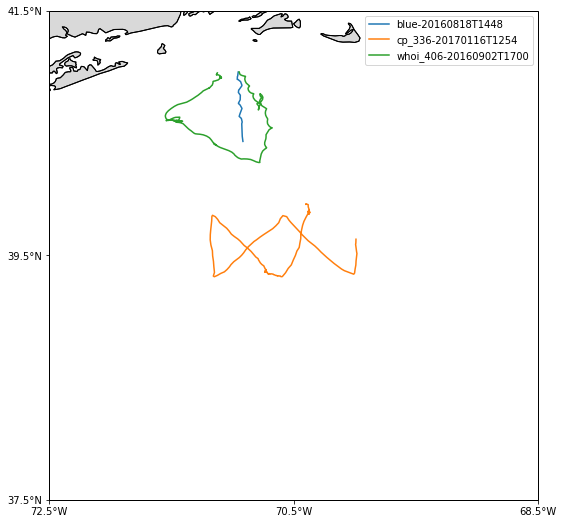

In [16]:
%matplotlib inline

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.pyplot as plt


projection = ccrs.PlateCarree()
fig, ax = plt.subplots(
    figsize=(9, 9),
    subplot_kw=dict(projection=projection)
)
ax.coastlines(resolution='10m')
dx = dy = 0.5
bbox = min_lon-dx, max_lon+dx, min_lat-dy, max_lat+dy
ax.set_extent(bbox)
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=[0.85]*3)
ax.add_feature(land, zorder=0)
ax.coastlines('10m', zorder=1)

for glider, df in dfs.items():
    ax.plot(df['longitude'], df['latitude'], label=glider)

ax.set_xticks(np.linspace(bbox[0], bbox[1], 3), crs=projection)
ax.set_yticks(np.linspace(bbox[2], bbox[3], 3), crs=projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

leg = ax.legend()

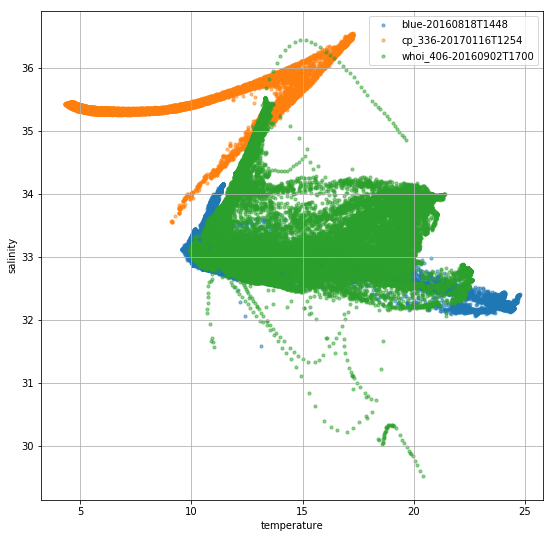

In [17]:
def glider_scatter(df, ax, glider):
    ax.scatter(df['temperature'], df['salinity'],
               s=10, alpha=0.5, label=glider)

fig, ax = plt.subplots(figsize=(9, 9))
ax.set_ylabel('salinity')
ax.set_xlabel('temperature')
ax.grid(True)

for glider, df in dfs.items():
    glider_scatter(df, ax, glider)

leg = ax.legend()